## Baseline search engine for EviDENce : WW2 Thesaurus##

Search strategy

1. Collect corpus to perform search on
2. Index documents in corpus
3. Collect Keywords
4. Perform search
6. Analyze results

Please see accompanying script baseline_search.py for detailed info. 

In [1]:
# Imports from python libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import string
import sys

# Imports from own script
from baseline_search import create_searchable_data
from baseline_search import create_searchable_data2
from baseline_search import create_lemma
from baseline_search import ceo_classes
from baseline_search import eng_to_dutch
from baseline_search import search_corpus
from baseline_search import quote_phrase

# disable SettingWithCopyWarning warning (default='warn')
pd.options.mode.chained_assignment = None 

In [2]:
# Define paths:

# to extracted folder with lemma fragments
root = os.path.join(os.sep,"media","sf_MartinedeVos")
manual_set = os.path.join(root,"TargetSize150","Manual_annotation_sets-20190110T093859Z-001")
search_dir = os.path.join(manual_set,"Auto_annotation_sets")
data = "../data/"

# to reports on baseline_search results
report = os.path.join(manual_set,"Reports")

# to keywords
ceo_file = os.path.join(data,"MdV_selectedCEOECB.csv")
transl_file = os.path.join(data,"Translated_lemmas.csv")
thes_file =os.path.join(data,"Geweldslexicon obv WOIIThesaurus SH en JW.csv")

# to ground truth
gt_file = os.path.join(manual_set,"Manual Annotation Jeroen en Susan","Manual annotation TOTAAL door Jeroen en Susan.csv")

### 1. Collect corpus to perform search on

Our corpus consists of oral history accounts.
These are broken up in text fragments -of 150 lemmas each- and can be found in a zip folder on surfdrive:

../Data/NR-teksts/EviDENce_NR_output/TargetSize150/Lemma_preserve_paragraph.zip

*Both the file names and path names are long. Make sure to extract the zip folder on high-level location on your computer a to avoid "path-too-long" error*


### 2. Index all documents (i.e., lemma fragments) in the directory ###

* Create Schema
* Add documents
* Perform indexing

_NB: this step only has to be run once, or when data is added or changed_

In [3]:
# The creation of an index is only needed once; after that, opending the existing index is sufficient
# in that case, the following line should be commented out

#create_searchable_data(search_dir)

### 3. Collect list of keywords from an existing vocabulary

Preprocessing entails:
* manually select keywords related to violence
* express keywords as lemmas to ensure more effective matching 

#### a.  Keywords from CEO-ECB mappings ####

Keywords based on mappings from classes of the Circumstantial Event Ontology (CEO) on the ECB+ corpus
* translate selected keywords to Dutch

In [4]:
ceo_df = pd.read_csv(ceo_file,sep=';',encoding = "ISO-8859-1")
ceo_df['wordnet_lemma']=ceo_df.apply(lambda x:create_lemma(x['Mention']), axis=1)

NB: As automatic translation is not stable or does not provide sufficient results, please use following workaround

In [5]:
transl_df = pd.read_csv(transl_file,sep=',',encoding = "ISO-8859-1") 

ceo_df['Dutch']= transl_df['Dutch']
# Add quotes in case of multiple words to enable 'phrase queries'.
ceo_df['Dutch']= ceo_df.apply(lambda x:quote_phrase(x['Dutch']), axis=1)
ceo_list = list(ceo_df['Dutch'])

ceo_df[0:10]

,lemma ID,Lemma,Mention,Provenance,Corpus Frequency,CEO class,CEO class.1,CEO class.2,wordnet_lemma,Dutch
0,12,alarm.v,alarm,automatic,7.0,/M,NaN,NaN,alarm,alarm
1,21,armed.a,armed,automatic,1.0,BeingArmed,NaN,NaN,arm,arm
2,23,arrest.n,arrest,automatic,30.0,Arresting,NaN,NaN,arrest,arresteren
3,23,arrest.v,arrested,automatic,100.0,Arresting,NaN,NaN,arrest,arresteren
4,23,NaN,arresting,automatic,1.0,Arresting,NaN,NaN,arrest,arresteren
5,23,NaN,arrests,automatic,10.0,Arresting,NaN,NaN,arrest,arresteren
6,24,arson,arson,automatic,21.0,Arson,NaN,NaN,arson,brandstichting
7,25,assassinate,assassinate,automatic,3.0,Murder,NaN,NaN,assassinate,vermoorden
8,25,assassination,assassination,automatic,2.0,Murder,NaN,NaN,assassination,moord
9,26,assault.n,assault,automatic,25.0,Attacking,NaN,NaN,assault,aanval


Create dictionary with CEO class per unique keyword

#### b.  Keywords from WW2 Thesaurus ####

The WW2 Thesaurus describes keywords related to events, locations, concepts and objects from the second world war.

In [6]:
thes_df = pd.read_csv(thes_file,sep=',',encoding = "ISO-8859-1")
thes_df[45:60]

,Label,Susan,Jeroen
45,KriegsfÃ¼hrung,NaN,NaN
46,Oorlogvoering,NaN,Oorlogvoering
47,Warfare,NaN,NaN
48,Barricades,NaN,NaN
49,Versperringen,NaN,NaN
50,Barrieren,NaN,NaN
51,Grebbe line,NaN,NaN
52,Grebbelinie,NaN,NaN
53,Grebbe-Linie,NaN,NaN
54,Wannseeconferentie,NaN,NaN


Manual selection of relevant violence keywords is done by two annotators;
We could either take the union (at least one of the annotators agrees) or intersection (both annotators agree) of the keyword selections

In [7]:
susan = thes_df['Susan'].dropna().str.lower().tolist()
jeroen = thes_df['Jeroen'].dropna().str.lower().tolist()

thes_intersect = [x for x in susan if x in jeroen]
thes_union = set(susan+jeroen)

print("At least one annotator. Nr keywords: %s" %len(thes_intersect))
print("Both annotators. Nr keywords: %s" %len(thes_union))

At least one annotator. Nr keywords: 111
Both annotators. Nr keywords: 308


### 4. Perform search ###

Documents are analyzed on the presence of at least one of the keywords (_OR group_) and results are sorted by their _TF IDF_ score. 

Results are stored in a pandas dataframe, which contains
* all keywords, also those that are not present in documents
* all documents, also those that have no keywords

Original corpus size: 976 
Percentage documents with at least one keyword: 14.03688524590164 
Total number of keywords used in query: 111 
Percentage keywords found wrt to those used in query: 20.72072072072072 



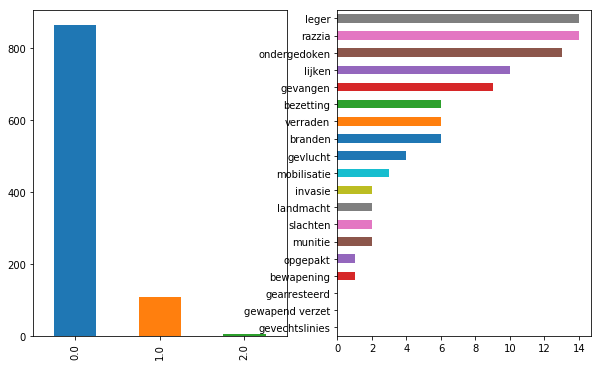

In [18]:
indexdir = os.path.join(os.sep,search_dir,"indexdir")

# Search results for selected keyword list
results_df, merged_df = search_corpus(indexdir,thes_intersect)

**Additional analyses**

In [19]:
sum_keywords = pd.Series(merged_df.sum().iloc[:-1])

# Keywords not present in corpus
missed_keywords = sum_keywords[sum_keywords == 0].index.values
missed_keywords

array(['aanslagen', 'arbeidsinzet', 'arrestaties', 'atoomoorlog',
       'atoomwapens', 'bombardementen', 'bommen', 'burgerdoelen',
       'burgeroorlogen', 'cavalerie', 'concentratiekampen', 'deportaties',
       'discriminatie', 'dodenlijsten', 'dodenmarsen', 'doodstraf',
       'doodvonnissen', 'doorgangskampen', 'duitse invasie',
       'dwangarbeid', 'dwangarbeiders', 'executies', 'explosieven',
       'frontlinies', 'gaskamers', 'gearresteerd',
       'gedwongen prostitutie', 'genietroepen', 'geschut',
       'getransporteerd', 'getroffen', 'gevechtshandelingen',
       'gevechtslinies', 'gevochten', 'gewapend verzet', 'geweldpleging',
       'gewonden', 'ghetto', 'gijzelaarskampen', 'interneringskampen',
       'jongenskampen', 'kanonneerboten', 'kindertransport',
       'kindertransporten', 'kindsoldaten', 'luchtaanvallen',
       'luchtmacht', 'luchtoorlog', 'machinegeweren', 'massa-executies',
       'massamoorden', 'meidagen 1940', 'mijnenleggers', 'mishandeling',
       'of

In [11]:
#ceo_classes(ceo_df,merged_df)

### 5. Comparison with groundtruth ###

a.  From ground truth: determine which fragments are relevant, i.e., related to violence 

In [20]:
# Prepare ground truth dataframe
gt_df = pd.read_csv(gt_file,sep=',',encoding = "ISO-8859-1") 

# Random set for manual annotation contains duplicate fragments; remove these
gt_all_df = gt_df.drop_duplicates(subset = ['Titel'])
# Select all violent fragments
gt_vio_df = gt_all_df[gt_all_df['EINDOORDEEL_janee']== 'ja']

# Add columns with clean titles to enable comparison
titles = gt_vio_df['Titel'].tolist()
new_titles = [title.split('_text')[0] for title in titles]
se = pd.Series(new_titles)
gt_vio_df['clean title'] = se.values

b. From baseline search: determine which fragments are correctly marked as violent

In [21]:
merged_df['hits']=merged_df.sum(axis=1)
base_vio_df = merged_df[merged_df['hits'] > 0]

# Add columns with clean titles to enable comparison
titles = base_vio_df.index.values.tolist()
new_titles = [title.split('_lemma')[0] for title in titles]
se = pd.Series(new_titles)
base_vio_df['clean title'] = se.values

# Select correctly annotated violent fragments
base_vio_df['correct']= base_vio_df['clean title'].isin(gt_vio_df['clean title'])

c. Determine recall and precision

In [22]:
relevant = len(gt_vio_df['clean title'])
retrieved = len(base_vio_df['clean title'])
correct_retrieved = len(base_vio_df[base_vio_df['correct'] == True])

recall = correct_retrieved/relevant
precision = correct_retrieved/retrieved

print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))


Recall: 0.19672131147540983
Precision: 0.3185840707964602
